In [1]:
"""
Created on Fri May 18 23:44:52 2018

@author: rocio
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import customutils

# Dataset Exploration

This dataset contains adverse effects reported for different people. This file contains information about the product, the patient (age and gender) and a the list of the adverse effects observed in these patients. The fields included in the dataset are:

- RA_Report #
- RA_CAERS Created Date
- AEC_Event Start Date
- PRI_Product Role
- PRI_Reported Brand/Product Name
- PRI_FDA Industry Code
- PRI_FDA Industry Name
- CI_Aget at Adverse Event
- CI_Age Unit
- CI_Gender
- AEC_One Row Outcomes
- SYM_One Row Coded Symptoms


First of all, we will read the data from a tsv file:

In [2]:
df = pd.read_csv("./CAERS_ASCII_2004_2017Q2.tsv", sep="\t")
df.columns

Index(['Unnamed: 0', 'RA_Report #', 'RA_CAERS Created Date',
       'AEC_Event Start Date', 'PRI_Product Role',
       'PRI_Reported Brand/Product Name', 'PRI_FDA Industry Code',
       'PRI_FDA Industry Name', 'CI_Age at Adverse Event', 'CI_Age Unit',
       'CI_Gender', 'AEC_One Row Outcomes', 'SYM_One Row Coded Symptoms'],
      dtype='object')

In [3]:
df.describe()

,Unnamed: 0,RA_Report #,PRI_FDA Industry Code,CI_Age at Adverse Event
count,90786.000000,90786.000000,90786.000000,52926.000000
mean,45392.500000,156577.560538,43.058082,50.755319
std,26207.805106,40382.318513,16.553049,23.249385
min,0.000000,65325.000000,2.000000,0.000000
25%,22696.250000,125985.250000,29.000000,35.000000
50%,45392.500000,168433.000000,54.000000,53.000000
75%,68088.750000,190410.750000,54.000000,68.000000
max,90785.000000,214610.000000,54.000000,736.000000


# Categories and products

To make easier de column references we will change the column names. In addition, we will remove duplicates of the resulting dataframe.

In [4]:
df_products = df[['PRI_Reported Brand/Product Name', 
                 'PRI_FDA Industry Code', 
                 'PRI_FDA Industry Name']]

df_products.columns = ['productname', 'categorycode', 'categoryname']
df_products = df_products.drop_duplicates()
df_products.head()

,productname,categorycode,categoryname
0,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing
2,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod
3,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod
4,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Prod
5,"FRITO LAY FUNYUNS ONION FLAVOR, ONION RINGS",7,Snack Food Item


In [5]:
df_products.shape

(46002, 3)

## How many different elements are there in each column?

In [6]:
#Number of category codes
dfsum = pd.DataFrame(data=[['categorycodes', len(df_products.categorycode.unique())], 
                           ['categorynames', len(df_products.categoryname.unique())],
                           ['porductnames', len(df_products.productname.unique())]],
                     columns = ['column', 'nuniquevalues'])
dfsum

,column,nuniquevalues
0,categorycodes,44
1,categorynames,41
2,porductnames,45685


## Why is the number of 'category codes' different to the number of 'category names'?

It should have some codes with the same name. Let's check it.

In [7]:
df_categories = df_products[['categorycode', 'categoryname']]
df_categories = df_categories.drop_duplicates()

In [8]:
df_categories_count = customutils.count(df_categories, ['categorycode'])
df_categories_count[df_categories_count['count']>1]

,categorycode,count
0,2,2


The category with code 2 has two names: 

In [9]:
df_categories[df_categories['categorycode']==2]['categoryname']

156      Whole Grain/Milled Grain Prod/Starch
63953                           Not Available
Name: categoryname, dtype: object

We observed, that in some rows, the name of the category with code 2 is missing. We'll replace 'Not Available' for 'Whole Grain/Milled Grain Prod/Starch' for solving this issue.

In [10]:
df_products.shape

(46002, 3)

In [11]:
df_products.loc[df_products['categorycode']==2, ['categoryname']] = 'Whole Grain/Milled Grain Prod/Starch'
df_categories.loc[df_categories['categorycode']==2, ['categoryname']] = 'Whole Grain/Milled Grain Prod/Starch'
df_products.shape

(46002, 3)

### Are there names with several category codes?

In [12]:
df_categories_count = customutils.count(df_categories, ['categoryname'])
df_categories_count = df_categories_count[df_categories_count['count']>1]
df_categories_count

,categoryname,count
20,Fruit/Fruit Prod,3
17,Food Additives (Human Use),2
37,Vegetables/Vegetable Products,2
39,Whole Grain/Milled Grain Prod/Starch,2


It seems that some category codes have the same name. Are the products related with those cageories different?

** Answer: ** * Several large food-related industries are assigned more than one industry code. These are Fruit and Fruit Products, Vegetables and Vegetable Products, and Food Additives. The easiest way to code products in multiple industry codes is by name search. Enter a word related to the product and review the list that the application returns. If you do select an industry code first, be sure to select all the codes assigned to the product group. For example Fruit and Fruit Products are assigned Industry Codes 20, 21 and 22. Select all three codes to search for all Fruit and Fruit-related products.* https://www.accessdata.fda.gov/scripts/ora/pcb/index.cfm?action=tutorial.tutorial


## ** Products: ** How many products are there for each category?

In [13]:
df_product_count = customutils.count(df_products, ['categorycode', 'categoryname'])
df_product_count.head()

,categorycode,categoryname,count
43,54,Vit/Min/Prot/Unconv Diet(Human/Animal),22373
42,53,Cosmetics,4154
1,3,Bakery Prod/Dough/Mix/Icing,1832
16,23,Nuts/Edible Seed,1529
22,29,Soft Drink/Water,1501


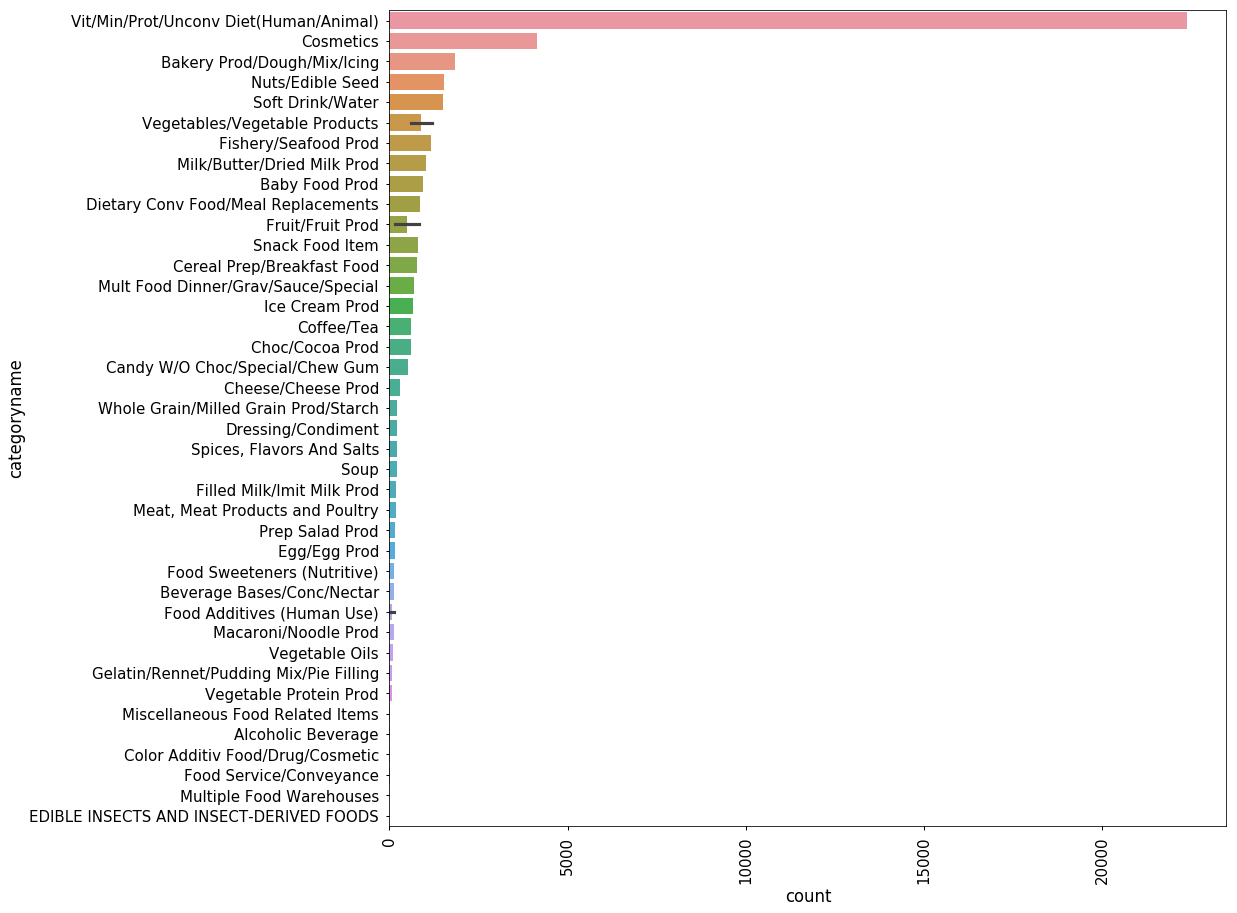

In [14]:
plt.figure(figsize=(15,15))

sns.set_context("notebook", font_scale=1.5)

p = sns.barplot(x='count', y='categoryname', data=df_product_count)
for item in p.get_xticklabels():
    item.set_rotation(90)

plt.show()

## How many categories are related with each product?

In [15]:
df_products.head()

,productname,categorycode,categoryname
0,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing
2,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod
3,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod
4,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Prod
5,"FRITO LAY FUNYUNS ONION FLAVOR, ONION RINGS",7,Snack Food Item


In [16]:
df_products_count = customutils.count(df_products, ['productname'])
df_products_count.columns = ['productname', 'ncategories']
df_count_freq = customutils.count(df_products_count, ['ncategories'])

In [17]:
df_count_freq

,ncategories,count
0,1,45428
1,2,230
2,3,23
3,4,3
4,33,1


In [18]:
df_products_count.head()

,productname,ncategories
35179,REDACTED,33
22108,LITTLE DEBBIE NUTTY BARS,4
41786,TURMERIC,4
36165,SALAD,4
14302,GARLIC,3


Finally, we will remove the prodructs labeled as "REDACTED".

In [19]:
df_products.shape

(46002, 3)

In [20]:
df_products = df_products[df_products.productname != 'REDACTED']
df_products.shape

(45969, 3)

# Sumary

- We have explored the dataset to know better the relationships betweet products and categories.
- We have detected that category 2 is wronly labeled in some rows.
- Some categories group many products (fruits, vegetables..) so there are more than one category code for these categories.
- We have remove the product with name "REDACTED" because it is not possible to figure out the real product name.
- We have done a preeliminary exploration of the distribution the producs an categories and we have seen that a category is very frequent in the data set: "Vit/Min/Prot/Unconv diet(Human/Animal)"

In [21]:
df_products.shape

(45969, 3)